### AdventureWorks Sales Data Analysis

In [1]:
#install and import these libararies...
import pyodbc 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime
#magic function for inline charts in notebook
%matplotlib inline
#For chart style from matplotlib 
plt.style.use('fivethirtyeight')

In [2]:
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                      "Server=serverName;"
                      "Database=AdventureWorksDW2012;"
                      "Trusted_Connection=yes;")
df = pd.read_sql_query("select * FROM [AdventureWorks2012].[Sales].[vw_salesoverview] order by OrderDate", cnxn)

### Sales KPI

In [3]:
#Lets print some KPI's 
print(
    "Total Sales: " + str('{:,.0f}'.format(round(df.Sales.sum()/1000)))
    + " Order Count: " + str('{:,.0f}'.format(round(df.OrderCount.sum()/1000)))
    + " Order Quantity: " + str('{:,.0f}'.format(round(df.OrderQuantity.sum()/1000)))
)

Total Sales: 80,488 Order Count: 61 Order Quantity: 215


### Overall Sales Trend

In [4]:
df['Month_Year'] = df['OrderDate'].apply(lambda x: x.strftime('%Y-%m'))

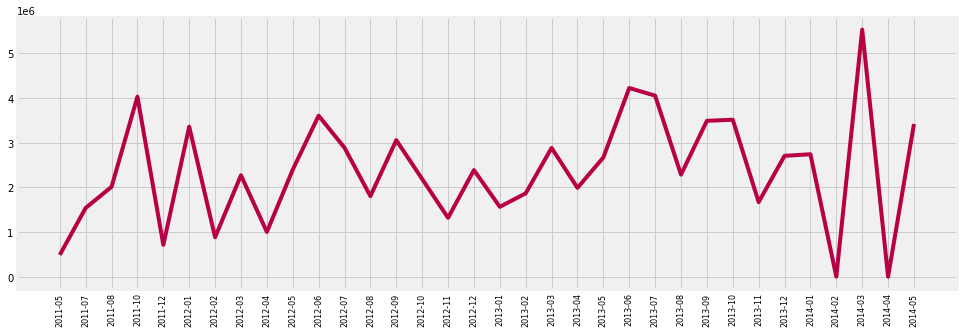

In [6]:
result = df.groupby('Month_Year').sum()
months = [month for month, df in df.groupby('Month_Year')]
plt.figure(figsize=(15,5))
plt.plot(months, result['Sales'], color= "#b80045")
plt.xticks(months, rotation='vertical', size= 8)
#plt.ylabel('Sales in (USD)')
#plt.xlabel('Months')
plt.show()

### Which are the Top 10 products by sales?

In [8]:
prod_sales = df.groupby('product').sum()[['OrderQuantity', 'Sales']]
prod_sales.sort_values(by=['Sales'], inplace=True, ascending=False)
# get top ten 
pd.options.display.float_format = '{:,.2f}'.format
top_prods = prod_sales.head(10)
top_prods

,OrderQuantity,Sales
product,,
"Mountain-200 Black, 38",2395,"3,105,726.66"
"Mountain-200 Black, 42",2050,"2,646,352.67"
"Mountain-200 Silver, 38",1798,"2,354,215.23"
"Mountain-200 Silver, 42",1674,"2,181,044.29"
"Mountain-200 Silver, 46",1636,"2,133,156.84"
"Mountain-200 Black, 46",1491,"1,936,203.67"
"Road-250 Black, 44",1371,"1,888,480.05"
"Road-250 Black, 48",1200,"1,656,449.69"
"Road-350-W Yellow, 48",1390,"1,380,253.88"


### Montly Sales Comparison same period last year.

In [9]:
ndf = df[['OrderDate', 'Sales']]

In [24]:
#add continous date to dataframe to calculate sameperiod last year data
new_df = ndf.groupby('OrderDate').sum().reset_index()
new_df = new_df.drop_duplicates('OrderDate').set_index('OrderDate').asfreq('D', fill_value=0)
new_df = new_df.sort_index().reset_index()
#new_df.head()

In [11]:
new_df['Previous'] = new_df.groupby([new_df['OrderDate'].dt.month,new_df['OrderDate'].dt.day])['Sales'].shift()
#new_df

In [12]:
new_df['Month_Year'] = new_df['OrderDate'].apply(lambda x: x.strftime('%Y-%m'))
#new_df

In [13]:
new_df = new_df.groupby('Month_Year').sum()[['Sales','Previous']]
#new_df.head()

Text(0, 0.5, 'Sales')

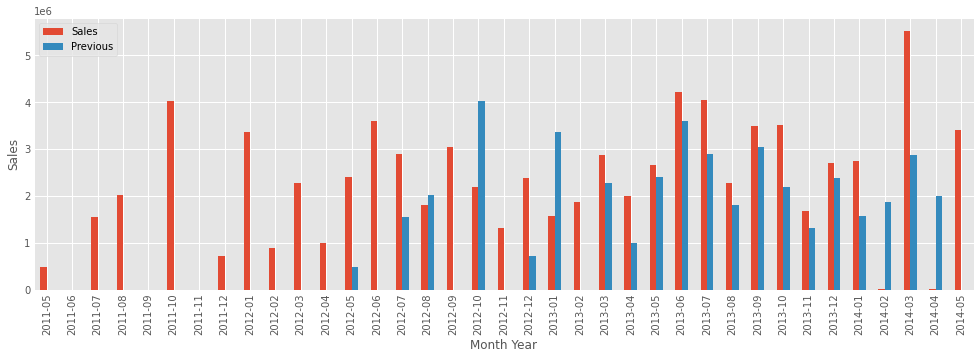

In [16]:
plt.style.use('ggplot')
new_df.plot(kind="bar",figsize=(15,5))
plt.xlabel('Month Year')
plt.ylabel('Sales')

### 100 Stacked chart by Country and Category

In [17]:
df_chart = df.groupby(['Country','productcategory']).sum()['Sales'].reset_index()
df_chart = pd.DataFrame(df_chart)
#df_chart.head()

In [18]:
cumsum = df_chart.groupby('Country').sum().groupby('Country').cumsum().reset_index()

In [19]:
df_combined = pd.merge(df_chart, cumsum, on='Country')

In [20]:
df_combined['sales_pr'] = df_combined['Sales_x'] /df_combined['Sales_y']
df_combined.drop(['Sales_x', 'Sales_y'] , axis=1, inplace=True)
#df_combined.head()

In [21]:
dfp = pd.pivot_table(df_combined, values="sales_pr", index=["Country"], columns='productcategory').reset_index()

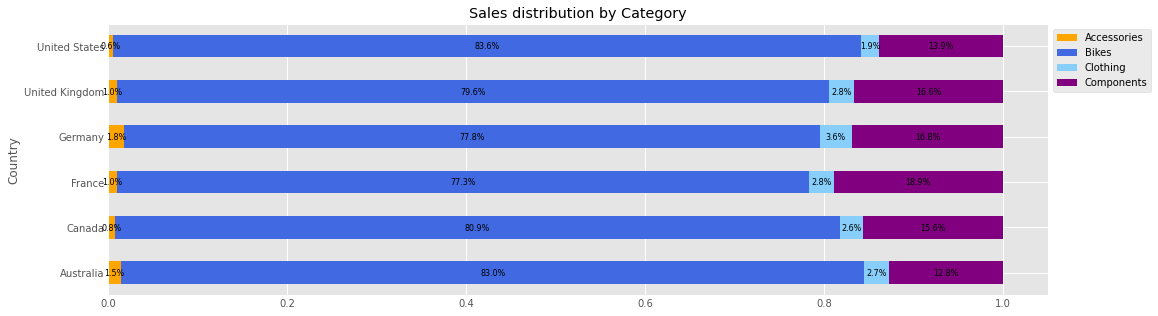

In [23]:
dfp.plot(
x = "Country",
kind="barh",
stacked= True,
figsize=(15,5),
  color=["orange", "royalblue", "lightskyblue", "purple"],
    title= "Sales distribution by Category",
    mark_right= True
)
plt.legend(bbox_to_anchor=(1.0, 1.0))
#
df_total = dfp["Accessories"] + dfp["Bikes"] + dfp["Clothing"] + dfp["Components"] 
df_rel = dfp[dfp.columns[1:]].div(df_total, 0) * 100
#
for n in df_rel: 
    for i, (cs, ab, pc) in enumerate(zip(dfp.iloc[:, 1:].cumsum(1)[n],  
                                         dfp[n], df_rel[n])): 
        plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%',  
                 va = 'center', ha = 'center',  fontsize = 8)